In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10, SVHN
import torchvision
from torchvision import transforms
import torchvision.utils as vision_utils
import matplotlib.pyplot as plt
import random
import os
import time
import math

DEVICE = torch.device('cuda')

In [11]:
def switch_to_device(dataset,device=None):
    final_X, final_Y = [], []
    for x, y in dataset:
        final_X.append(x)
        final_Y.append(y)
    X = torch.stack(final_X)
    Y = torch.tensor(final_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return torch.utils.data.TensorDataset(X, Y)


def get_mnist_dl(batch_size_train=256, batch_size_eval=256, device=torch.device('cpu')):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = MNIST('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000,5000])
    
    data_test = MNIST('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [12]:

class MLP_Net(nn.Module):

  def __init__(self, num_classes=10) -> None:
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(28*28, 1024)
    self.Relu1 = nn.ReLU()
    self.fc2 = nn.Linear(1024, 1024)
    self.Relu2 = nn.ReLU()
    self.fc3 = nn.Linear(1024, num_classes)
    #self.softmax = nn.Softmax()


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.flatten(x)
    x = self.Relu1(self.fc1(x))
    x = self.Relu2(self.fc2(x))
    x = self.fc3(x)
    
    return x

In [13]:
class CNN_Net(nn.Module):
    def __init__(self, num_classes=10) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 26, kernel_size=5, stride=1, padding = 0)
        self.maxpooling1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(26, 52, kernel_size=3, stride=1, padding = 0)

        self.conv3 = nn.Conv2d(52, 10, kernel_size=1, stride=1, padding=0)
        self.maxpooling3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_1 = nn.Linear(5*5*10, 1000)
        self.fc_2 = nn.Linear(1000, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.maxpooling1(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.maxpooling3(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [14]:
def print_stats(stats):

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3), dpi=110)
  ax1.grid()
  ax2.grid()

  ax1.set_title("ERM loss")
  ax2.set_title("Valid Acc")
  
  ax1.set_xlabel("iterations")
  ax2.set_xlabel("iterations")

  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1] for x in stats['train-loss']]
  ax1.plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  ax2.plot(itrs, acc)

  ax1.set_ylim(0.0, 4.05)
  ax2.set_ylim(0.0, 1.05)


@torch.no_grad()
def get_acc(model, dl):
  model.eval()
  acc = []
  for X, y in dl:
    #acc.append((torch.sigmoid(model(X)) > 0.5) == y)
    acc.append(torch.argmax(model(X), dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  return acc.item()


In [15]:
def run_experiment(model, opt, train_dl, valid_dl, test_dl, use_forward_grad=False, num_forward_grad=1, max_epochs=20, cal_grad_change = False, use_momentum = False, fix_gap = 0, shuffle_ratio = 0.2, decay_rate = 0.8):

  itr = -1
  stats = {'train-loss': [], 'valid-acc':[]}
  time_list = []
  sort_index_dict = {}
  master_dir = {}
  angle_with_true = []
  for i, p in enumerate(model.parameters()):
    sort_index_dict[i] = []
    master_dir[i] = 0

  for epoch in range(max_epochs):
    for x, y in train_dl:
        itr += 1
        layer_inputs = {}
        def hook(mod, input):
            layer_inputs[mod] = input[0]
        for module in model.modules():
            module.register_forward_pre_hook(hook)
        opt.zero_grad()
        start = time.time()
        loss = F.cross_entropy(model(x), y)
        loss.backward()
        
        if itr % 1 == 0:
          if cal_grad_change:
            with torch.no_grad():
              for i, p in enumerate(model.parameters()):
                g = p.grad.view(-1)
                index_sort = torch.argsort(g).to(torch.device('cpu'))
                sort_index_dict[i].append(index_sort)
        
        if use_forward_grad:
          with torch.no_grad():
            if use_momentum:
              if itr % fix_gap == 0:
                for i, p in enumerate(model.parameters()):
                  g = p.grad.view(-1)
                  index_sort = torch.argsort(g)
                  master_dir[i] = index_sort
            for i, p in enumerate(model.parameters()):
              g = p.grad.view(-1)
              v = torch.randn(num_forward_grad, len(g), device=DEVICE)
              
              if use_momentum:
                for j in range(num_forward_grad):
                  v[j] = torch.sort(v[j]).values
                  #v[j] = torch.from_numpy(np.array([x for _,x in sorted(zip(master_dir[i].tolist(), v[j].tolist()), key=lambda pair: pair[0])]))
                  tmp = torch.zeros(len(v[j])).to(DEVICE).long()
                  tmp_dir = torch.tensor([]).to(DEVICE).long()
                  for k in range(int(1/shuffle_ratio)):
                    if k<(int(1/shuffle_ratio)-1):
                      partial_master_dir = master_dir[i][int(k*shuffle_ratio*master_dir[i].nelement()) : int((k+1)*shuffle_ratio*master_dir[i].nelement())]
                    else:
                      partial_master_dir = master_dir[i][int(k*shuffle_ratio*master_dir[i].nelement()) : ]
                    partial_shuffle_idx = torch.randperm(partial_master_dir.nelement())
                    partial_tmp_dir = partial_master_dir[partial_shuffle_idx]
                    tmp_dir = torch.cat((tmp_dir, partial_tmp_dir))
                  tmp[tmp_dir] = torch.arange(len(v[j])).to(DEVICE)
                  v[j] = v[j][tmp]
                ber_matrix = torch.full(v.shape, 0.5)
                random_index = torch.bernoulli(ber_matrix).to(DEVICE)
                v = v + random_index*v*(-2)
                v = torch.randn(num_forward_grad, len(g), device=DEVICE)*(1-decay_rate**(itr%fix_gap)) + v*(decay_rate**(itr%fix_gap))
              
              g = ((v @ g).view(num_forward_grad,1) * v).mean(dim=0)
              angle_with_true.append((torch.dot(p.grad.view(-1), g)/(torch.linalg.norm(p.grad.view(-1))*torch.linalg.norm(g))).cpu().item())
              
              p.grad = g.view(p.grad.shape)
        
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.25, norm_type=2)
        opt.step()
        time_list.append(time.time()-start)

        stats['train-loss'].append((itr, loss.item()))

        if itr % 100 == 0:
          valid_acc = get_acc(model, valid_dl)
          stats['valid-acc'].append((itr, valid_acc))
          s = f"{epoch}:{itr} [train] loss:{loss.item():.3f}, [valid] acc:{valid_acc:.3f}, time: {np.sum(time_list)/100}"
          print(s)
          time_list = []

        if itr % 200 == 0:
          decay_rate = decay_rate**2

  test_acc = get_acc(model, test_dl)
  print(f"[test] acc:{test_acc:.3f}")
  if cal_grad_change:
    return (stats, sort_index_dict), angle_with_true
  else:
    return (stats), angle_with_true

0:0 [train] loss:2.344, [valid] acc:0.150, time: 2.0015239715576173e-05
0:100 [train] loss:1.624, [valid] acc:0.574, time: 0.001479337215423584
0:200 [train] loss:0.511, [valid] acc:0.860, time: 0.001617746353149414
1:300 [train] loss:0.316, [valid] acc:0.901, time: 0.0016823101043701172
1:400 [train] loss:0.291, [valid] acc:0.922, time: 0.0018591785430908203
2:500 [train] loss:0.162, [valid] acc:0.931, time: 0.001997249126434326
2:600 [train] loss:0.195, [valid] acc:0.938, time: 0.001928095817565918
3:700 [train] loss:0.211, [valid] acc:0.941, time: 0.002091386318206787
3:800 [train] loss:0.187, [valid] acc:0.948, time: 0.0021606707572937012
4:900 [train] loss:0.142, [valid] acc:0.949, time: 0.002358591556549072
4:1000 [train] loss:0.190, [valid] acc:0.953, time: 0.002288625240325928
[test] acc:0.959


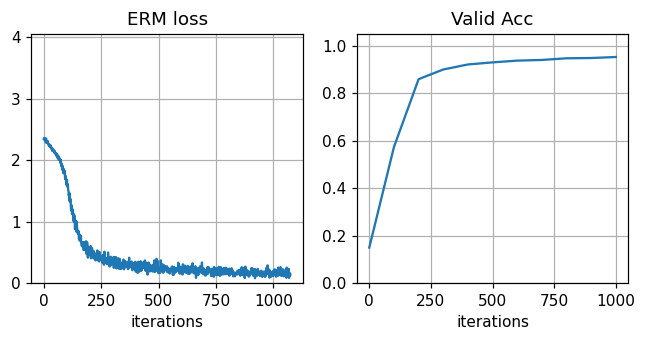

In [16]:
train_dl, valid_dl, test_dl = get_mnist_dl(device=DEVICE)

model = CNN_Net().to(DEVICE)

for p in model.parameters():
    g = p.view(-1)
    v = torch.normal(mean = torch.full((1, len(g)), 0.), std = torch.full((1, len(g)), 0.1)).to(DEVICE)
    p.data = v.view(p.shape)

opt = torch.optim.SGD(model.parameters(), lr=1e-2)


res, angle_with_true= run_experiment(model, opt, train_dl, valid_dl, test_dl, use_forward_grad=False, num_forward_grad = 1, max_epochs=5, cal_grad_change = False, use_momentum = True, fix_gap = 10, shuffle_ratio = 0.2, decay_rate = 0.9)

if type(res).__name__ == 'dict':
    print_stats(res)
else:
    stats = res[0]
    sort_index = res[1]
    print_stats(stats)


In [17]:
def print_index_change(sort_index, layer):
    sorted_lists = sort_index[layer]
    bottom1_index = sorted_lists[0][len(sorted_lists[0])//2]
    print(len(sorted_lists))
    changing_list = []
    for sorted_list in sorted_lists:
        a = sorted_list.tolist().index(bottom1_index)
        print(a)
        changing_list.append(a)
    return changing_list
    '''
    angle_list = []
    dir_1 = sorted_lists[0]
    for dir_2 in sorted_lists:
        angle_list.append(np.dot(dir_1, dir_2)/(np.linalg.norm(dir_1)*np.linalg.norm(dir_2)))
        #dir_1 = dir_2
    return angle_list
    '''
        

In [18]:
layer_num = 1
index_list = print_index_change(sort_index, layer_num)
plt.ylim(0, len(sort_index[layer_num][0])*1.1)
plt.plot(index_list)

NameError: name 'sort_index' is not defined

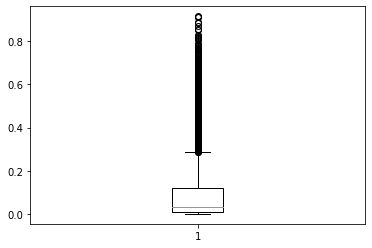

In [ ]:
#angle_with_true = angle_with_true.tolist()
plt.boxplot(angle_with_true);

In [ ]:
np.mean(angle_with_true)

0.09458995782419641